## 1. User Input

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
api_key = "API_KEY"
rh_user = "user"
rh_pass = "pass"
demo_run = True

## 2. Downloading Robinhood orders
It will prompt MFA (if you have it enabled). Run again if you want refreshed Robinhood data.

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pyrh import Robinhood
if not demo_run:
    client = Robinhood(username=rh_user, password=rh_pass)
    client.login()
else:
    client = None

In [5]:
from backend.robinhood_data import RobinhoodData
rh = RobinhoodData('data/', client)
if demo_run:
    demo_orders = rh.demo_orders()
    demo_dividends= rh.demo_dividends()
else:
    demo_orders = None
    demo_dividends= None
dividends, orders, open_positions, closed_positions = rh.download(demo_orders, demo_dividends)

## 3. Download stock prices and market index
Rerun if you want fresh market data

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from backend.market_data import download_save_market_data

market = download_save_market_data(
    api_key=api_key,
    symbols=orders.symbol.unique(),
    start_date=orders.date.min(),
    end_date=pd.Timestamp("today", tz='UTC'))

## 4. Portfolio Models

In [7]:
from backend.portfolio_models import PortfolioModels
import empyrical as emp

In [8]:
# main calculations section
ptf = PortfolioModels('data')
summary = ptf.portfolio_summary()
stocks = ptf.stocks_risk()
df_corr, df_cov = ptf.stocks_correlation()
ptf_stats = ptf.portfolio_stats()
markowitz = ptf.markowitz_portfolios()
investment, dividends = ptf.portfolio_returns()

## 5. Results

### 5.1 Portfolio summary

In [9]:
summary

,Shares,Portfolio weight,Current cost basis,Current value,Realized P/L,Dividends,Unrealized P/L,Total return,Total return rate
symbol,,,,,,,,,
AAPL,100,29.04%,"10,000.00","38,823.00",0.00,30.00,"28,823.00","28,853.00",288.53%
BA,100,13.46%,"10,000.00","17,996.00",0.00,80.00,"7,996.00","8,076.00",80.76%
BAC,100,1.81%,"10,000.00","2,414.00",0.00,100.00,"-7,586.00","-7,486.00",-74.86%
BND,100,6.63%,"10,000.00","8,869.00",0.00,60.00,"-1,131.00","-1,071.00",-10.71%
CAT,100,10.24%,"10,000.00","13,688.00",0.00,70.00,"3,688.00","3,758.00",37.58%
CVX,100,6.61%,"10,000.00","8,835.00",0.00,40.00,"-1,165.00","-1,125.00",-11.25%
JPM,100,7.35%,"10,000.00","9,821.00",0.00,110.00,-179.00,-69.00,-0.69%
MSFT,80,12.47%,"8,000.00","16,668.00",400.00,20.00,"8,668.00","9,088.00",113.60%
SPY,0,0.00%,0.00,0.00,0.00,0.00,0.00,0.00,-0.69%


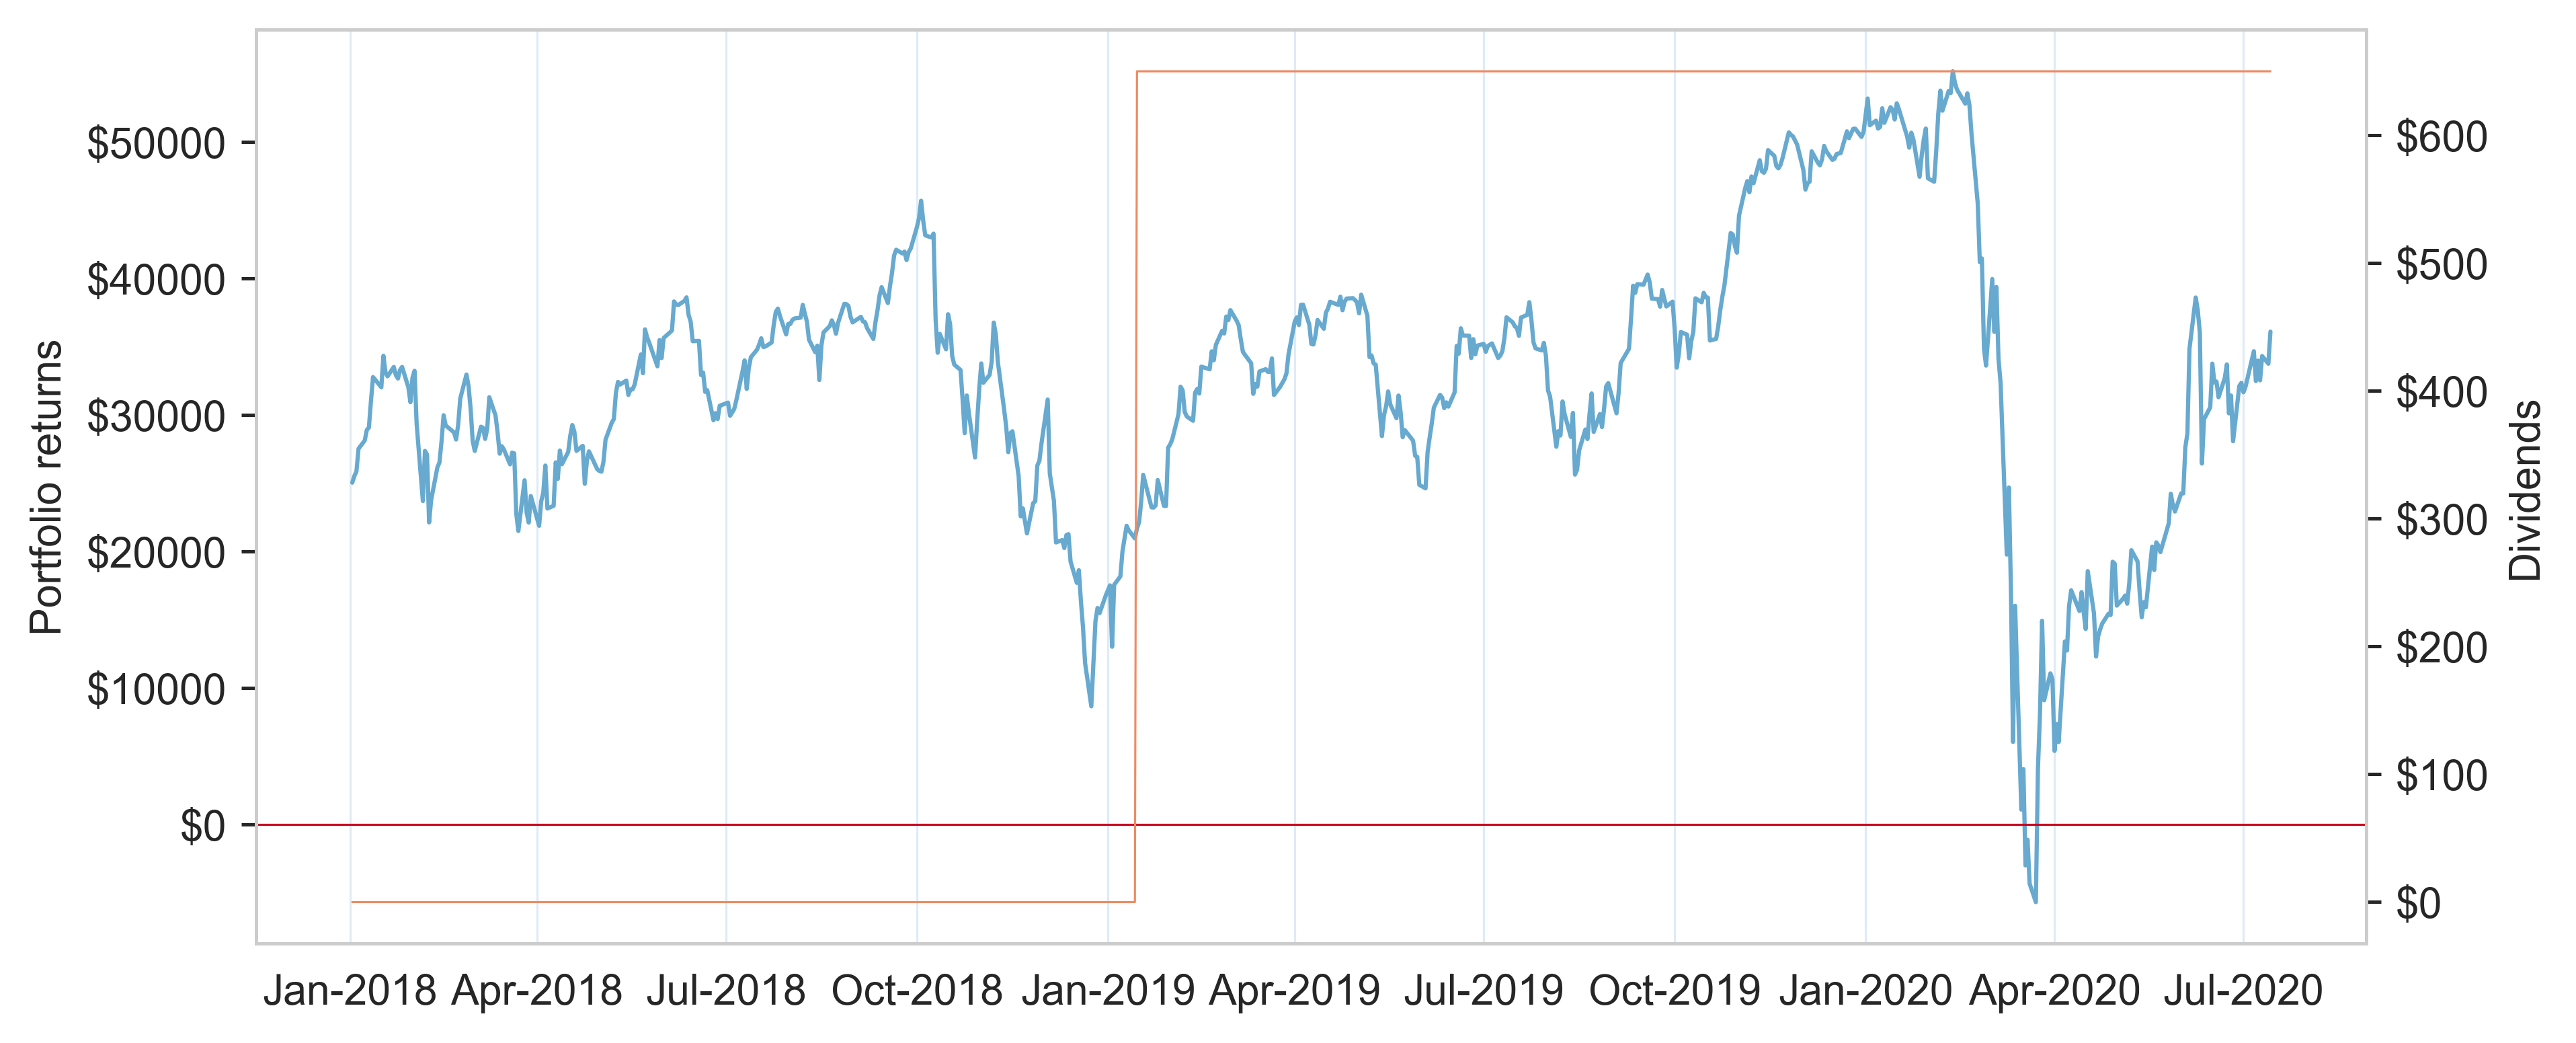

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
sns.set_style("whitegrid")
MY_DPI = 450

f, ax1 = plt.subplots(figsize=(9, 4), dpi=MY_DPI)
ax2 = ax1.twinx()

ax1.plot(investment, linewidth=1, color='#67a9cf')
ax1.axhline(y=0, color='#ca0020', linestyle='-', linewidth=0.5)
ax1.set_ylabel("Portfolio returns")

ax2.plot(dividends, linewidth=0.5, color='#ef8a62')
ax2.set_ylabel("Dividends")

# format y-axis
ax1.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: '${:.0f}'.format(x)))

ax2.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: '${:.0f}'.format(x)))

# format dates and grids
date_fmt = mdates.DateFormatter('%b-%Y')
ax1.xaxis.set_major_formatter(date_fmt)

ax1.grid(False, axis='both', linestyle='-', linewidth=0.5, color="#deebf7")
ax1.grid(b=None, axis='y')

ax2.grid(False, axis='both', linestyle='-', linewidth=0.5, color="#deebf7")
ax2.grid(b=None, axis='y')

plt.show()

### 5.2 Portfolio Stats

In [11]:
ptf_stats

Total return           0.374949
Market return          0.186591
Annual return         -0.016760
Annual volatility      0.341516
Sharpe ratio           0.124115
Calmar ratio          -0.034203
Stability              0.060215
Max drawdown          -0.490007
Omega ratio            1.024068
Sortino ratio          0.163251
Skew                  -1.082623
Kurtosis               9.264294
Tail ratio             0.859260
Daily value at risk   -0.031676
Alpha                 -0.052195
Beta                   1.300359
dtype: float64

### 5.3 Stocks performance

In [12]:
stocks

,Annual return,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk,Alpha,Beta
symbol,,,,,,,,,,,,,,
AAPL,0.226396,0.342056,0.769797,0.538901,0.373297,-0.420107,1.157103,1.055386,-0.783518,7.819217,0.928482,-0.031956,0.243828,1.165671
BA,-0.422184,0.587732,-0.622644,-0.494355,0.443259,-0.854010,0.871487,-0.796956,-1.511642,17.468480,0.804067,-0.049218,-0.350604,1.693029
BAC,-0.217185,0.399469,-0.409566,-0.378743,0.411156,-0.573437,0.919397,-0.538833,-0.767005,12.036453,0.757915,-0.041442,-0.195344,1.388642
BND,0.030548,0.064281,0.500542,0.338381,0.761663,-0.090277,1.138037,0.650201,-3.374275,83.973079,1.086752,-0.003274,0.031424,0.031933
CAT,-0.174659,0.370707,-0.329231,-0.298308,0.735219,-0.585500,0.942474,-0.427625,-0.964579,5.862426,0.849551,-0.038000,-0.154176,1.173834
CVX,-0.271144,0.410713,-0.551648,-0.388724,0.504410,-0.697524,0.880372,-0.685546,-2.701228,35.749722,0.948608,-0.031822,-0.241166,1.275100
JPM,-0.156240,0.363374,-0.282651,-0.302915,0.209642,-0.515789,0.942777,-0.374297,-0.865874,14.189775,0.919735,-0.031696,-0.140574,1.261753
MSFT,0.274730,0.327157,0.907718,0.792046,0.851694,-0.346862,1.191459,1.263576,-0.777422,12.009987,0.897665,-0.031228,0.285302,1.186969
SPY,0.008823,0.242611,0.159211,0.023105,0.006886,-0.381868,1.034678,0.206748,-1.334136,15.018970,0.658203,-0.023897,0.000000,1.000000


### 5.4 Correlations

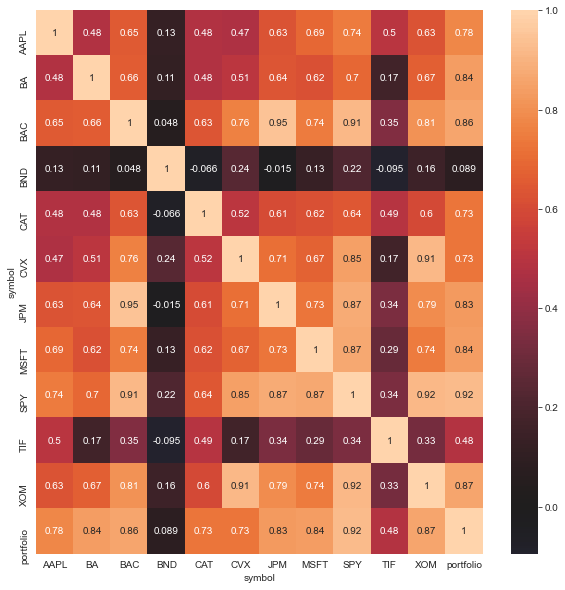

In [13]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ax=ax, data=df_corr, center=0, annot=True)

### 5.5 Markowitz

In [14]:
for l in markowitz:
    print(l['name'])
    print(l['weights'])
    print('\n')

Minimum variance portfolio
symbol
AAPL    6.648165e-11
BA      4.138511e-11
BAC     2.738030e-10
BND     9.736285e-01
CAT     1.286203e-02
CVX     3.572508e-11
JPM     3.938554e-03
MSFT    6.615183e-10
TIF     9.570914e-03
XOM     5.064078e-11
dtype: float64


Target: more than 50% of stock returns
symbol
AAPL    6.440468e-11
BA      3.811872e-11
BAC     2.712212e-10
BND     9.736285e-01
CAT     1.286203e-02
CVX     3.377226e-11
JPM     3.938555e-03
MSFT    6.809876e-10
TIF     9.570914e-03
XOM     4.838471e-11
dtype: float64


Target: more than 75% of stock returns
symbol
AAPL    6.452477e-11
BA      3.864678e-11
BAC     2.705161e-10
BND     9.736285e-01
CAT     1.286203e-02
CVX     3.410858e-11
JPM     3.938555e-03
MSFT    6.709637e-10
TIF     9.570914e-03
XOM     4.885041e-11
dtype: float64


Target: more than 90% of stock returns
symbol
AAPL   -3.887644e-10
BA     -3.413824e-10
BAC    -1.437104e-10
BND     1.143824e-01
CAT    -1.516481e-10
CVX    -1.967346e-10
JPM     7.868181e-11
